## Brain decoding prediction analysis

This notebook compares quantitative properties of the brain decoder predictions for different trained decoders / subjects / target representations.

In [1]:
from collections import defaultdict
import itertools
from pathlib import Path
import re
import sys

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
from scipy import stats as st
from tqdm import tqdm_notebook
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2

sys.path.append("../src")
from rsa import rsa_encodings
import util

In [2]:
decoder_path = Path("../models/decoders")
bert_encoding_path = Path("../models/bert")
sentences_path = Path("../data/sentences/stimuli_384sentences.txt")
brains_path = Path("../data/brains")

bert_base_model = "uncased_L-12_H-768_A-12"
finetune_desc = "finetune-250"

In [82]:
bert_models = ["SST", "SQuAD", "LM_pos", "MNLI", "QQP", "LM", "LM_contentonly", "LM_lmonly", "LM_randommask", "LM_scrambled", "LM_contentonly_scrambled", "LM_lmonly_scrambled"]
# Models which should appear in the final report figures
report_models = ["SQuAD", "QQP", "MNLI", "SST", "LM", "LM_scrambled", "LM_pos"]
subjects = ["M02", "M04", "M07", "M08", "M09", "M14", "M15", "P01"]
target_runs = [1, 2, 3, 4, 5, 6, 7, 8, 9]
steps = list(range(5, 255, 5))

In [83]:
figure_path = Path("../reports/figures")
figure_path.mkdir(exist_ok=True)

### Data loading

In [84]:
PCA_DIM = 256

In [129]:
# Load model encoding data.
encodings = {}
steps_of_interest = [steps[-1]]
for model, run, step in tqdm_notebook(list(itertools.product(bert_models, target_runs, steps_of_interest)), desc="Loading model steps"):
    encoding_name = "encodings.%s.%s.%s-run%i-%i.npy" % (finetune_desc, bert_base_model, model, run, step)
    encoding_path = bert_encoding_path / encoding_name

    try:
        encodings[model, run, step] = util.load_encodings([encoding_path], project=PCA_DIM)
    except FileNotFoundError:
        print(model, run, step)
        continue

SST 9 250
SQuAD 9 250
LM_pos 5 250
LM_pos 6 250
LM_pos 7 250
LM_pos 8 250
LM_pos 9 250
MNLI 9 250
QQP 9 250
LM 9 250
LM_contentonly 9 250
LM_lmonly 9 250
LM_randommask 5 250
LM_randommask 6 250
LM_randommask 7 250
LM_randommask 8 250
LM_randommask 9 250
LM_contentonly_scrambled 9 250
LM_lmonly_scrambled 9 250



In [86]:
encs2 = {"/".join(str(x) for x in k): v for k, v in encodings.items()}

In [87]:
np.savez("../models/bert_encodings_20190518-1242.npz", **encs2)

In [88]:
# Load decoder prediction data.
predictions = {}
for subject in tqdm_notebook(subjects, desc="Subjects"):
    for model, run, step in tqdm_notebook(list(itertools.product(bert_models, target_runs, steps_of_interest)), desc="Loading predictions for target models", leave=False):
        decoded_path = decoder_path / ("encodings.%s.%s.%s-run%i-%i-%s.pred.npy" % (finetune_desc, bert_base_model, model, run, step, subject))
        try:
            predictions[model, run, step, subject] = np.load(decoded_path)
        except FileNotFoundError: pass
        
    # Add baseline predictions.
    baseline_path = decoder_path / ("encodings.%s-%s.pred.npy" % (bert_base_model, subject))
    predictions["_", None, None, subject] = np.load(baseline_path)

In [89]:
preds2 = {"/".join(str(x) for x in k): v for k, v in predictions.items()}

In [90]:
np.savez("../models/decoder_predictions_20190518-1242.npz", **preds2)

#### Reload from cache ..

If restarting this notebook, we can hopefully load the cached files instead:

In [130]:
predictions = np.load("../models/decoder_predictions_20190518-1242.npz")
predictions = {tuple(k.split("/")): v for k, v in predictions.items()}
encodings = np.load("../models/bert_encodings_20190518-1242.npz")
encodings = {tuple(k.split("/")): v for k, v in encodings.items()}

In [131]:
# Normalize encodings as in regression.
encodings = {k: v - v.mean(axis=0) for k, v in encodings.items()}
encodings = {k: v / np.linalg.norm(v, axis=1, keepdims=True) for k, v in encodings.items()}

### Prepare sentence data

In [132]:
sentences = util.load_sentences(sentences_path)

### Load original encodings

In [133]:
# Load pretrained model encodings.
encoding_path = bert_encoding_path / ("encodings.%s.npy" % (bert_base_model))
baseline_encoding = util.load_encodings([encoding_path], project=PCA_DIM)

### Error analysis

Averaging across subjects, how does per-sentence error change over time?

In [134]:
pred_mses = {}

In [135]:
for (model, run, step), encodings_i in encodings.items():
    mses = {}
    for subject in subjects:
        try:
            mses_s = np.linalg.norm(encodings_i - predictions[model, run, step, subject], axis=1)
        except:
            continue
        
        mses[subject] = pd.Series(mses_s, name="mse")
        
    if mses:
        pred_mses[model, int(run), int(step)] = pd.concat(mses, names=["subject"])

In [136]:
# Add original encoding MSEs.
original_mses = {}
for subject in subjects:
    original_mses[subject] = pd.Series(np.linalg.norm(baseline_encoding - predictions["_", "None", "None", subject], axis=1),
                                       name="mse")
    pred_mses["_", 0, 250] = pd.concat(mses, names=["subject"])

In [137]:
pred_mses = pd.DataFrame(pd.concat(pred_mses, names=["model", "run", "step"])).sort_index()
pred_mses.index.names = ["model", "run", "step", "subject", "sentence"]

In [138]:
pred_mses.head()

mse
model run step subject sentence          
LM    5   250  M02     0         1.092201
                       1         1.158309
                       2         1.239335
                       3         1.100847
                       4         0.993001

In [139]:
first_mses = pred_mses.loc[pd.IndexSlice["_", 0, 250, :, :], :]
last_mses = pred_mses.loc[pd.IndexSlice[:, :, 250, :, :], :]

In [140]:
first_mses.index = first_mses.index.droplevel((0, 1, 2))

In [141]:
mse_diffs = last_mses.groupby(["model", "run", "step"]) \
    .apply(lambda xs: xs.reset_index(level=(0,1,2), drop=True) - first_mses)

In [142]:
mse_diffs.head()

mse
model run step subject sentence          
LM    5   250  M02     0         0.154692
                       1         0.063970
                       2         0.153121
                       3         0.150697
                       4        -0.010885

In [143]:
mse_diffs["abs_mse"] = mse_diffs.mse.transform(np.abs)

In [144]:
mse_diffs.sort_values("abs_mse", ascending=False)

mse   abs_mse
model               run step subject sentence                    
SST                 4   250  M02     9         0.693673  0.693673
                    2   250  P01     273       0.686453  0.686453
                    6   250  M09     366       0.672251  0.672251
                    2   250  M07     59        0.663484  0.663484
                    5   250  P01     273       0.662324  0.662324
QQP                 3   250  M09     380       0.660901  0.660901
SST                 2   250  M08     237       0.653982  0.653982
                             P01     364       0.652862  0.652862
                    6   250  M15     378       0.645233  0.645233
                    5   250  M15     378       0.643740  0.643740
                    4   250  P01     77        0.640519  0.640519
                    2   250  M02     364       0.640462  0.640462
                    7   250  M09     260      -0.639112  0.639112
                    2   250  M14     230       0.638560  0.638560
                    6   250  P01     364       0.633426  0.633426
                    2   250  M09     108       0.633293  0.633293
                             M04     273       0.631253  0.631253
                             M15     378       0.624403  0.624403
                    5   250  M09     274       0.621540  0.621540
SQuAD               6   250  M07     9         0.619779  0.619779
SST                 4   250  M02     361       0.619024  0.619024
                             M15     144       0.616722  0.616722
                    5   250  M08     360       0.615656  0.615656
                    1   250  M15     144       0.613378  0.613378
                    8   250  P01     364       0.609214  0.609214
                    5   250  P01     202       0.606936  0.606936
                    3   250  M09     108       0.603271  0.603271
                    2   250  M02     361       0.603099  0.603099
                    8   250  P01     273       0.599907  0.599907
                    3   250  M14     144       0.598629  0.598629
...                                                 ...       ...
LM_lmonly_scrambled 8   250  M14     101       0.000000  0.000000
                                     100       0.000000  0.000000
                                     99        0.000000  0.000000
                                     98        0.000000  0.000000
                                     97        0.000000  0.000000
                                     117       0.000000  0.000000
                                     119       0.000000  0.000000
                                     141       0.000000  0.000000
                                     131       0.000000  0.000000
                                     140       0.000000  0.000000
                                     139       0.000000  0.000000
                                     138       0.000000  0.000000
                                     137       0.000000  0.000000
                                     136       0.000000  0.000000
                                     135       0.000000  0.000000
                                     134       0.000000  0.000000
                                     133       0.000000  0.000000
                                     132       0.000000  0.000000
                                     130       0.000000  0.000000
                                     120       0.000000  0.000000
                                     129       0.000000  0.000000
                                     128       0.000000  0.000000
                                     127       0.000000  0.000000
                                     126       0.000000  0.000000
                                     125       0.000000  0.000000
                                     124       0.000000  0.000000
                                     123       0.000000  0.000000
                                     122       0.000000  0.000000
                          

### RSA in MSE diffs between models

In [145]:
avg_mse_diffs = mse_diffs.groupby(["model"]).apply(lambda xs: xs.groupby("sentence").abs_mse.mean())
avg_mse_diffs.head()

sentence,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
model,,,,,,,,,,,,,,,,,,,,,
LM,0.082508,0.056656,0.044380,0.074071,0.061686,0.059294,0.075532,0.071338,0.056020,0.151549,...,0.051695,0.062736,0.049203,0.040290,0.066216,0.056500,0.073965,0.043602,0.044003,0.042324
LM_contentonly,0.076721,0.054010,0.037143,0.055932,0.059122,0.052899,0.069035,0.064269,0.049760,0.122648,...,0.049702,0.040723,0.054240,0.042405,0.054867,0.045523,0.069986,0.044243,0.041012,0.044905
LM_contentonly_scrambled,0.057957,0.070212,0.049602,0.072459,0.052123,0.054763,0.053243,0.057292,0.044709,0.069795,...,0.038205,0.041233,0.047617,0.050035,0.046818,0.064029,0.054649,0.029040,0.029477,0.036465
LM_lmonly,0.072197,0.060036,0.044616,0.070441,0.067299,0.065415,0.086620,0.070024,0.050914,0.141237,...,0.062846,0.053105,0.050494,0.043855,0.054989,0.061462,0.082087,0.046044,0.054698,0.057257
LM_lmonly_scrambled,0.039500,0.061573,0.041207,0.049323,0.032154,0.033453,0.036770,0.044382,0.036474,0.044575,...,0.037406,0.045236,0.048237,0.036940,0.049229,0.045893,0.035476,0.023824,0.028196,0.039042


In [146]:
mse_corrs = {}
for pair in itertools.combinations(avg_mse_diffs.index, 2):
    mse_corrs[pair], _ = st.pearsonr(avg_mse_diffs.loc[pair[0]], avg_mse_diffs.loc[pair[1]])

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [147]:
heatmap = np.zeros((len(bert_models), len(bert_models)))
for i, model1 in enumerate(bert_models):
    for j, model2 in enumerate(bert_models):
            
        try:
            heatmap[i, j] = mse_corrs[model1, model2]
        except:
            heatmap[i, j] = mse_corrs.get((model2, model1), 1.0)

Text(0.5,1,'Correlation in sentence MSE diffs')

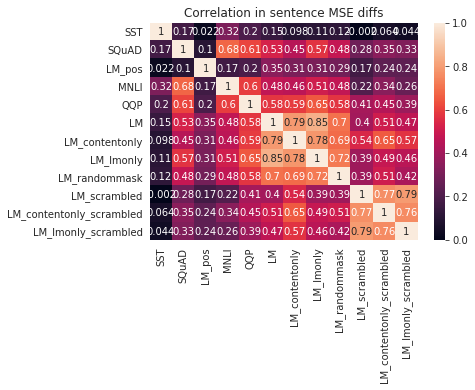

In [148]:
heatmap = pd.DataFrame(heatmap, index=bert_models, columns=bert_models)
sns.heatmap(data=heatmap, annot=True)
plt.title("Correlation in sentence MSE diffs")

### RSA in MSE diffs between model runs: LM_scrambled

In [149]:
avg_mse_diffs = mse_diffs.loc["LM_scrambled"].groupby("run").apply(lambda xs: xs.groupby("sentence").abs_mse.mean())
avg_mse_diffs.head()

sentence,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
run,,,,,,,,,,,,,,,,,,,,,
1,0.041789,0.078235,0.064638,0.058400,0.051741,0.050420,0.043541,0.050018,0.051249,0.078920,...,0.046524,0.052813,0.044586,0.053657,0.033357,0.061479,0.052386,0.023007,0.026518,0.038174
2,0.046808,0.069183,0.038294,0.062285,0.030529,0.078954,0.048250,0.051248,0.032601,0.042867,...,0.037734,0.040285,0.041274,0.041005,0.055670,0.050518,0.046311,0.018431,0.034335,0.021467
3,0.042503,0.071354,0.032968,0.048762,0.025177,0.050608,0.038958,0.048209,0.039293,0.028321,...,0.055454,0.047562,0.051558,0.035860,0.044745,0.067453,0.032731,0.016921,0.036427,0.039458
4,0.037233,0.098767,0.053598,0.072283,0.046496,0.029268,0.035703,0.034611,0.053377,0.047797,...,0.028201,0.039348,0.047650,0.060805,0.040175,0.068696,0.028276,0.017530,0.046953,0.061059
5,0.056523,0.074954,0.079305,0.086293,0.026519,0.049020,0.034325,0.066601,0.048876,0.045311,...,0.035077,0.034766,0.055841,0.051695,0.031768,0.058575,0.037870,0.037154,0.051396,0.046120


In [150]:
mse_corrs = {}
for pair in itertools.combinations(avg_mse_diffs.index, 2):
    mse_corrs[pair], _ = st.pearsonr(avg_mse_diffs.loc[pair[0]], avg_mse_diffs.loc[pair[1]])

In [151]:
idx = list(avg_mse_diffs.index)
heatmap = np.zeros((len(idx), len(idx)))
for i, model1 in enumerate(idx):
    for j, model2 in enumerate(idx):
            
        try:
            heatmap[i, j] = mse_corrs[model1, model2]
        except:
            heatmap[i, j] = mse_corrs.get((model2, model1), 1.0)

Text(0.5,1,'Correlation in sentence MSE diffs')

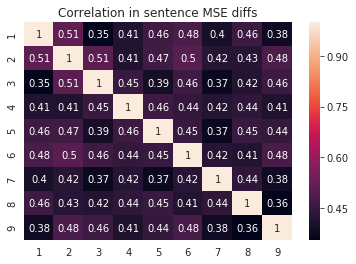

In [152]:
heatmap = pd.DataFrame(heatmap, index=idx, columns=idx)
sns.heatmap(data=heatmap, annot=True)
plt.title("Correlation in sentence MSE diffs")

Text(0.5,1,'LM_scrambled MSE diffs between runs')

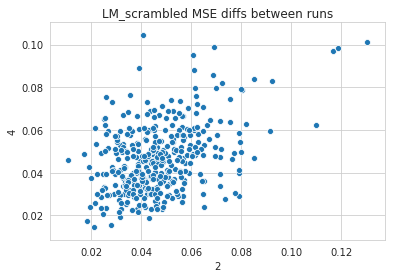

In [153]:
sns.scatterplot(x=2, y=4, data=avg_mse_diffs.T.reset_index())
plt.title("LM_scrambled MSE diffs between runs")

### RSA in MSE diffs between model runs: MNLI

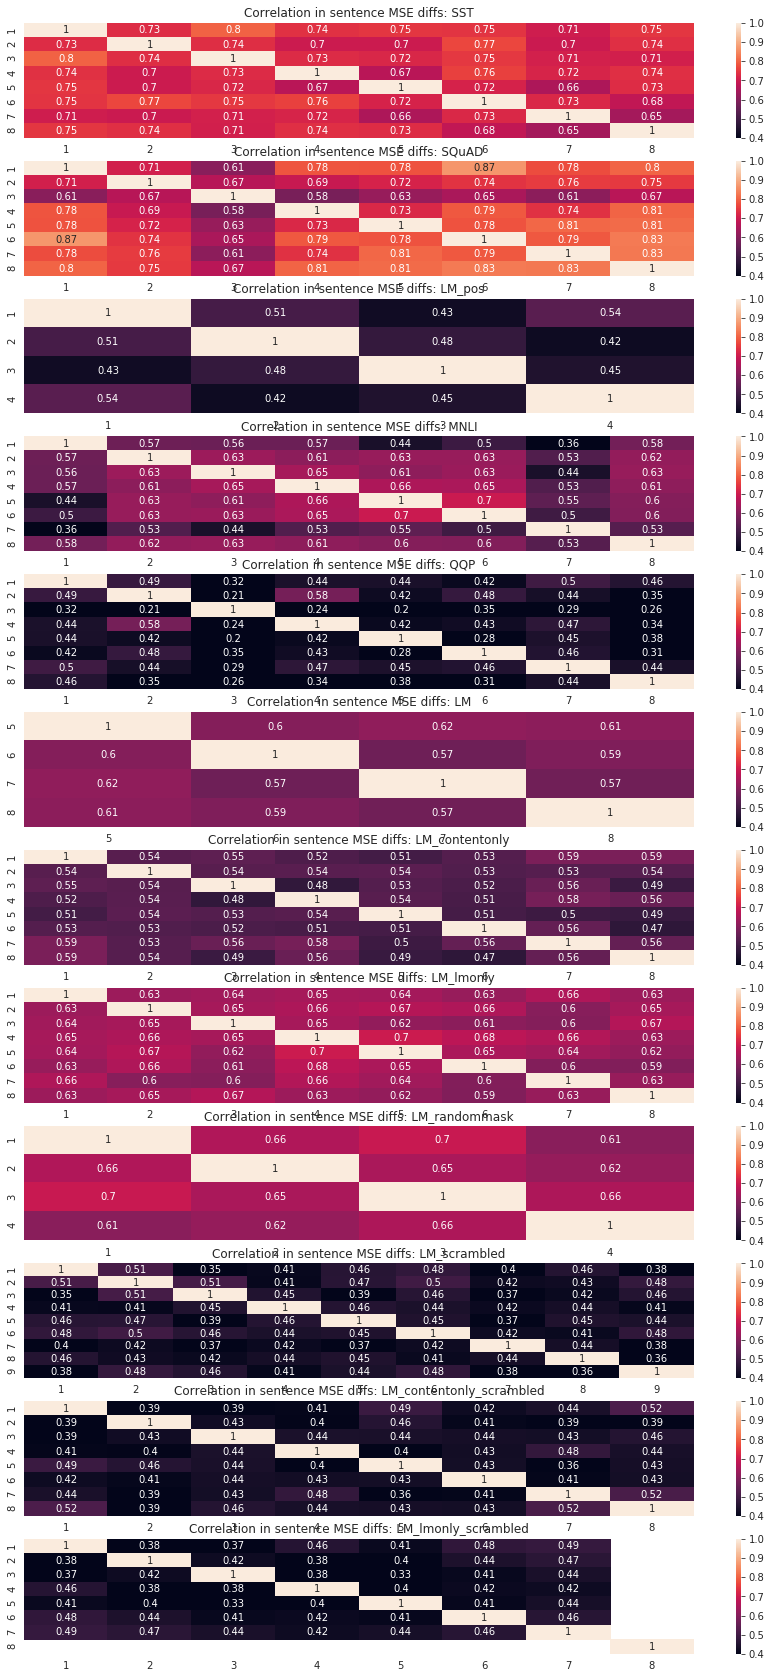

In [154]:
f, axs = plt.subplots(len(bert_models), figsize=(15, 30))
heatmaps = {}
for model, ax in tqdm_notebook(list(zip(bert_models, axs))):
    avg_mse_diffs = mse_diffs.loc[model].groupby("run").apply(lambda xs: xs.groupby("sentence").abs_mse.mean())
    mse_corrs = {}
    for pair in itertools.combinations(avg_mse_diffs.index, 2):
        mse_corrs[pair], _ = st.pearsonr(avg_mse_diffs.loc[pair[0]], avg_mse_diffs.loc[pair[1]])
        
    idx = list(avg_mse_diffs.index)
    heatmap = np.zeros((len(idx), len(idx)))
    for i, model1 in enumerate(idx):
        for j, model2 in enumerate(idx):

            try:
                heatmap[i, j] = mse_corrs[model1, model2]
            except:
                heatmap[i, j] = mse_corrs.get((model2, model1), 1.0)
                
    heatmaps[model] = pd.DataFrame(heatmap, index=idx, columns=idx)
    sns.heatmap(data=heatmaps[model], annot=True, ax=ax, vmin=0.4, vmax=1.0)
    ax.set_title("Correlation in sentence MSE diffs: %s" % model)

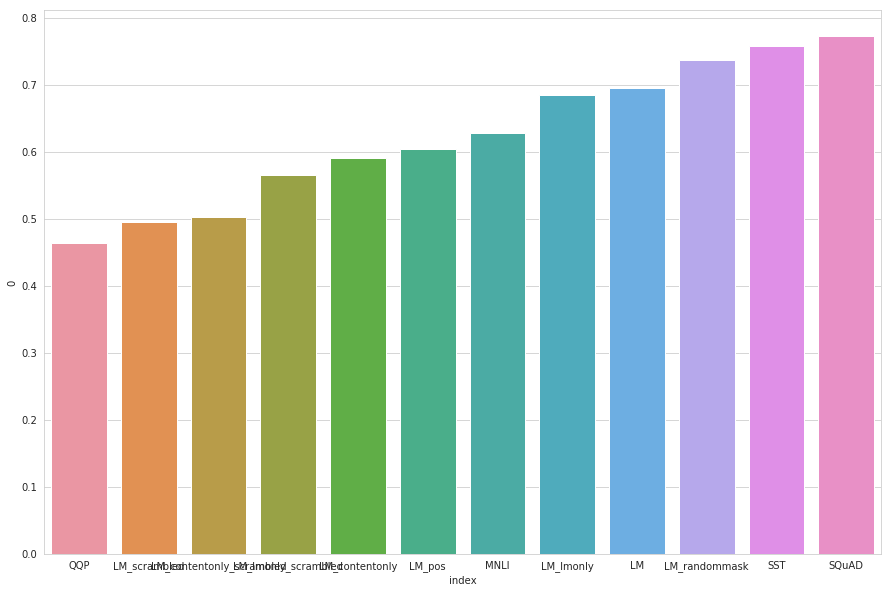

In [155]:
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="index", y=0, data=pd.DataFrame.from_dict({k: v.mean().mean() for k, v in heatmaps.items()}, orient="index").sort_values(0).reset_index())

### RSA content analysis

In [156]:
rsa_inputs = {(model, run, step): enc for (model, run, step), enc in encodings.items()
              if int(step) == steps[-1]}
rsa_sims = rsa_encodings(rsa_inputs, collapse_fn=lambda key: key[0])

100%|██████████| 3916/3916 [01:27<00:00, 44.91it/s]


In [157]:
rsa_sims_avg = rsa_sims.groupby(["model1", "model2"]).pearsonr.mean()
rsa_sims_avg

model1                    model2                  
LM                        LM                          0.981314
                          LM_contentonly              0.950050
                          LM_contentonly_scrambled    0.915645
                          LM_lmonly                   0.963069
                          LM_lmonly_scrambled         0.901259
                          LM_randommask               0.943505
                          LM_scrambled                0.898944
LM_contentonly            LM_contentonly              0.982326
                          LM_contentonly_scrambled    0.945839
                          LM_lmonly                   0.947187
                          LM_lmonly_scrambled         0.927462
                          LM_randommask               0.931055
                          LM_scrambled                0.925793
LM_contentonly_scrambled  LM_contentonly_scrambled    0.982915
                          LM_lmonly_scrambled         0.958354
LM_l

In [158]:
# Present sorted by avg correlation with LM_scrambled
rsa_sims_dict = rsa_sims_avg.to_dict()
rsa_sims_dict.update({(k2, k1): v for (k1, k2), v in rsa_sims_dict.items()})
model_order = sorted(bert_models, key=lambda m: rsa_sims_dict[m, "LM_scrambled"])
heatmap = np.zeros((len(model_order), len(model_order)))
for i, model1 in enumerate(model_order):
    for j, model2 in enumerate(model_order):
        try:
            heatmap[i, j] = rsa_sims_avg[model1, model2]
        except:
            heatmap[i, j] = rsa_sims_avg.get((model2, model1), 1.0)

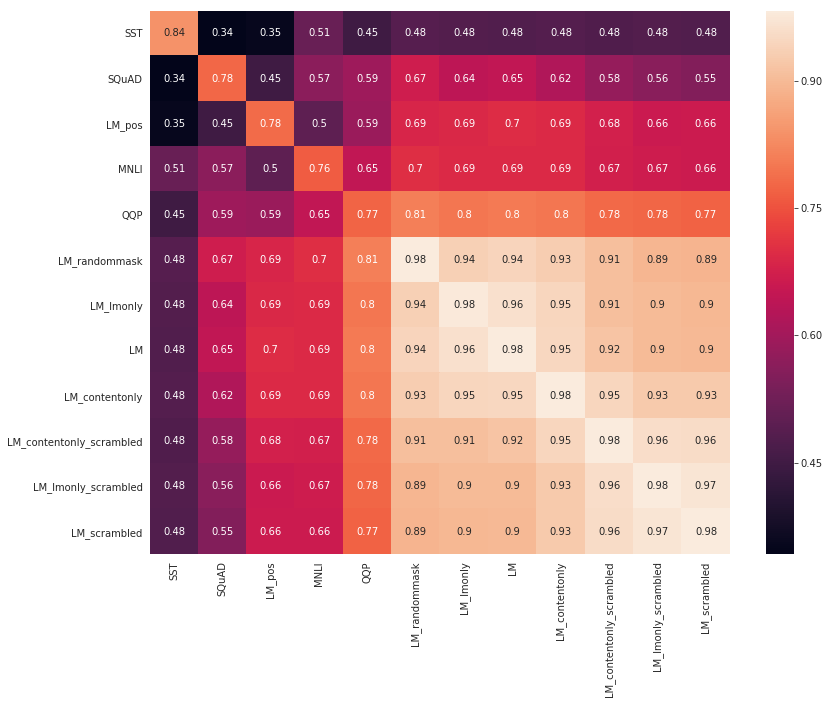

In [159]:
f, ax = plt.subplots(figsize=(13,10))
heatmap_df = pd.DataFrame(heatmap, index=model_order, columns=model_order)
sns.heatmap(data=heatmap_df, annot=True)

In [160]:
%matplotlib agg

# replot the above, but for report
rsa_sims_dict = rsa_sims_avg.to_dict()
rsa_sims_dict.update({(k2, k1): v for (k1, k2), v in rsa_sims_dict.items()})
model_order = sorted(report_models, key=lambda m: rsa_sims_dict[m, "LM_scrambled"])
heatmap = np.zeros((len(model_order), len(model_order)))
for i, model1 in enumerate(model_order):
    for j, model2 in enumerate(model_order):
        try:
            heatmap[i, j] = rsa_sims_avg[model1, model2]
        except:
            heatmap[i, j] = rsa_sims_avg.get((model2, model1), 1.0)
            
f, ax = plt.subplots(figsize=(13,10))
heatmap_df = pd.DataFrame(heatmap, index=model_order, columns=model_order)
sns.heatmap(data=heatmap_df, annot=True, annot_kws={"size": 15})
plt.tight_layout()
plt.savefig(figure_path / "rsa.png")
plt.close(f)

%matplotlib inline